## Applications of Stochastic Processes to Population Modelling: Ornstein-Uhlenbeck Process (OU)

This note aims to show how the Ornstein-Uhlenbeck process, a mean-reverting SDE, can be used to model birth/mortality rates of a population. We aim to:

- Discuss population models (birth rate, mortality rate, overall population) and how we can use stochastic models to reflect real world data
- Give an overview of the mathematics underlying the Stochastic Process (Derivation, Mean/Variance/Covariance, Limiting Distribution)
- Demonstrate how to identify a mean-reverting process using Unit Root Tests from Time Series Analysis (Dickey-Fuller test for AR(1) Process)
- Use Maximum Likelihood Estimation to estimate the parameters for the SDE based on a sample (historical data for birth/mortality rates of a country)
- Collect and store the data and use it to identify an OU process and calibrate our model
- Display the results on some graphs



---
## Introduction
---

A mean-reverting Ornstein-Uhlenbeck process $X_t$ with parameters $\mu, \theta, \sigma$ is characterised by the stochastic differential equation
$$dX_t = \theta(\mu - X_t)dt + \sigma dW_t$$

where $W_t$ is a standard Brownian Motion and $X_0 = x_0$ . The OU process is part of a family of diffusion processes widely used to model stochastic dynamics, most notably in finance for interest rates. The model is also used in population dynamics, which we will delve into later. 

The SDE above is interpreted as describing a linear drift process where the drift term ($dt$ component) prescribes a mean-reversion of $X_t$ towards the long term mean $\mu$ with an additional parameter $\theta$ describing the rate/speed of reversion. 

#### Solving the Ornstein-Uhlenbeck SDE

One can show that the analytical solution of the OU process is 

$$X_t = \mu + e^{-\theta T}(X_0 - \mu) + \sigma\int_0^T e^{-\theta(T-t)} dW_t$$

We can conclude that $X_t$ is normally distributed, due to Brownian Motion. The following are formulas for the mean, variance and covariance:

$$\mathbb{E} [X_t] = \mu + e^{-\theta T}(X_0 - \mu)$$

$$V[X_t] = \frac{\sigma^2}{2\theta}\left(1-e^{-2\theta T}\right)$$

$$C[X_t, X_S] = \frac{\sigma^2}{2\theta}\left( e^{-\theta |T-S|} - e^{-\theta(T+S)} \right)$$

Derivations for these formulae can be found in the handwritten note alongside this document.
#### Discretisation of Ornstein-Uhlenbeck SDE

While it's good to have the analytical formulae, if we want to simulate the SDE on a graph a discretised version is used instead. Discretised analogs are often used because analytical solutions to an SDE can't be found, so one has to obtain a numerical solution instead. One widely used approach to obtain this is the **Euler-Maruyama** approximation, where for a general SDE

$$X_t = a(X_t, t)dt + b(X_t, t)dW_t$$

where $X_0 = x_0$, we can approximation the solution on a time interval $[0,T]$ by using the following Markov chain:

- Partition the interval into $N$ equal subintervals of width $\Delta t = T/N$ and $0=\tau_0 < \tau_1 < ... < \tau_N = T$.
- With $Y_0 = x_0$, using recursion define $Y_n$ as
$$Y_{n+1} = Y_n + a(Y_n , \tau_n)\Delta t + b(Y_n , \tau_n)(W_{\tau_n+1} - W_{\tau_n})$$

By the properties of Brownian Motion, one can write $(W_{\tau_n+1} - W_{\tau_n}) = \sqrt{dt}\epsilon_t$, where $\epsilon_t \sim N(0,1)$. Applying this to our OU process, the Euler-Maruyama discretisation is

$$x_{t+1} = x_t + \theta(\mu - x_t)\Delta t + \sigma\sqrt{dt}\epsilon_t$$

This formula will be used later on in Python code.

#### Parameter Estimation for Ornstein-Uhlenbeck SDE

In our model we have three parameters that need to be set to simulate our SDE:
- $\theta$ : speed of reversion
- $\mu$ : long-term mean
- $\sigma$ : variance (volatility)

Often we will have real world data that can be fitted to a particular mathematical model. The reason why we might fit a model to data is because this can allow us to make predictions for future values of the data. If we determine that such a dataset (in our case, a time series) follows a mean-reverting process, **we can use the data observed to infer what the values of our parameters might be.** Once we have determined the correct values, we can fit the model as close as possible to our dataset. The inference method we will use here is **Maximum Likelihood Estimation (MLE)**

To give a more formal statement; given $n+1$ samples $\left\{ x_0, x_1, ... , x_n \right\} = \vec{\mathbf{x}}$ at times $t_0, t_1, ..., t_n$ respectively, the vector $\Theta = [\theta, \mu , \sigma]$ can be estimated using maximum likelihood.

Going back to our OU process, we can start by defining the Conditional Distribution:

$$X_t | X_{t-1} \sim N\left( X_{t-1}e^{-\theta \Delta t} + \mu \left( 1-e^{-\theta \Delta t} \right), \frac{\sigma^2}{2\theta}\left( 1-e^{-2\theta \Delta t} \right) \right)$$

where we define $\Delta t = t_{i} - t_{i-1} \; \forall i \;$ such that $1 \leq i \leq n$. We assume that all time observations are evenly spaced for simplicity.

We next need to use a likelihood function, which calculates the probability of observing the sample data given the parameter values set for the model. It is constructed from the joint probability distribution of the random variable that generated the observations. We denote this as

$$\mathcal{L}(\Theta; \vec{\mathbf{x}} ) = \prod_{i=1}^n f_{X_t | X_{t-1}}(x_{t_i})$$


where $f_{X_t | X_{t-1}}(x_{t_i})$ is the probability density function for the conditional distribution $X_t | X_{t-1}$. The **goal of MLE is to be able to maximise this function,** which can help us identify the optimal parameters for our model, that is we need to solve

$$\hat{\theta} = \underset{\theta \in \Theta}{\operatorname{argmax}} \mathcal{L}(\Theta, \vec{\mathbf{x}})$$

To fully derive the function, we know that the pdf for a normal distribution is 
$$f(x) = \frac{1}{\sqrt{2\pi \sigma^2}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})$$

so substituting in our mean and variance for the conditional distribution we get

$$\mathcal{L}(\Theta; \vec{\mathbf{x}} ) = \prod_{i=1}^n \left( \frac{1}{\sqrt{2\pi\tilde{\sigma}^2}}\exp \left( -\frac{1}{2\tilde{\sigma}^2}\left( x_{t_i} - \mu - (x_{t_i} - \mu)e^{-\theta \Delta t} \right)^2 \right)\right)$$

where $\tilde{\sigma}^2 = \frac{\sigma^2}{2\theta}(1-e^{-2\theta \Delta t})$. It is common practise to instead work with the **log-likelihood function,** which is allowed since logarithms are strictly increasing functions. This becomes

$$\ln\left( \mathcal{L}(\Theta; \vec{\mathbf{x}}) \right) = l(\Theta; \vec{\mathbf{x}}) \\[6pt]
    = -\frac{n}{2}\ln (2\pi) -\frac{n}{2}\ln \left(\frac{\sigma^2}{2\theta}\right) - \frac{n}{2}\ln \left(1-e^{-2\theta \Delta t}\right) \\[2pt] - \frac{\theta}{\sigma^2}\sum_{i=1}^n \left( \frac{1}{1-e^{-2\theta \Delta t}} \left( x_{t_i} - \mu - (x_{t_i} - \mu)e^{-2\theta \Delta t} \right)^2 \right)$$

There does exist analytical formulas for the optimal parameters for this model, but in our note we shall use *scipy.optimise* to solve this.


#### Time Series Analysis and Dickey-Fuller Test
The Ornstein-Uhlenbeck process can be considered as the continuous-time analogue of the discrete-time AR(1) process.

An AR(1) model, or an auto-regressive model of order 1, is defined as 

$$X_t = c + \phi_1 X_{t-1} + \epsilon_t$$

where $\phi_1$ is a parameter for the model, $c$ is a constant, and $\epsilon_t \sim N(0,1)$ is white noise.

Looking at the discretised version of the OU process $x_{t+1} = x_t + \theta (\mu - x_t)\Delta t + \sigma \sqrt{dt}\epsilon_t$ , we notice that we can set 

- $c = \theta \mu \Delta t$
- $b = 1-\theta \Delta t$
- $a = \sigma \sqrt{dt}$

which converts our OU process to a time series as described above!

$$x_t = c + b x_{t-1} + a \epsilon_t$$

One question that often arises in time series is the question of **stationarity:** does the mean of a time series stay constant over time? If a time series is stationary, this may indicate that we have a **mean-reverting process as well**, such as the OU process (it is important to note stationary does not always imply mean-reverting)

A popular test for checking stationarity is the **Dickey-Fuller test**, which checks for the presence of a unit root in a time series. If we modify our equation above we can set up our test

$$x_t  - x_{t-1}= c + b x_{t-1} + a \epsilon_t - x_{t-1} \rightarrow \Delta x_t = c + (b - 1) x_{t-1} + a \epsilon_t$$

and we let $\phi = b-1$ be our unit root. Our test will be

$$H_0 : \phi = 0 \\[2pt] 
H_1 : \phi < 0$$

where $H_0$ is our null hypothesis (time series is non-stationary) and $H_1$ is the alternative hypothesis (time series is stationary). From there we compute our test statistic to be 

$$t_{\hat{\phi}} = \frac{\hat{\phi}}{SE(\hat{\phi})} = \frac{1}{n}\frac{\frac{1}{2}(\chi_1^2 - 1)}{\int_0^1 W^2(t)dt}$$

where $\chi_1^2$ is our chi-squared distribution, $W^2(t)$ is our brownian motion and $n$ is the number of points in our time series. This test statistic will be compared against the so-called DF-distribution (DF standing for Dickey-Fuller) and our results can be interpreted as:

- $t_{\hat{\phi}} < DF_{critical} \implies $ Reject $H_0$
- $t_{\hat{\phi}} > DF_{critical} \implies $ Don't reject $H_0$

---
## Applications: Simulating Population Growth using the OU process
---

As we mentioned above, we will explore how we can use stochastic processes to model birth and mortality/death rates of different countries using the techniques we have described above.

For our data, we will investigate the mortality rates for the country of **Ecuador**, from the years 1970 to 2019, where mortality rates are expressed in units of deaths per 1,000 individuals per year. The data can be obtained for free from the World Bank Group DataBank: https://databank.worldbank.org/

Text(0.5, 1.0, 'Historical Mortality Rate of Ecuador')

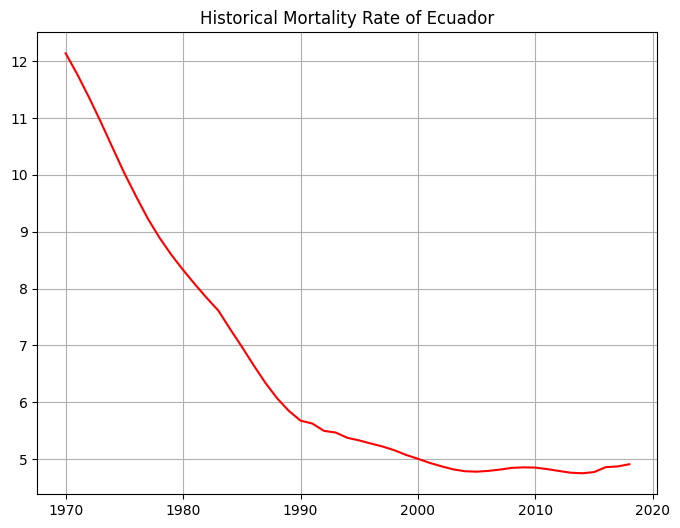

In [1]:
# Import the modules we will use
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics as stats
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import statsmodels.tsa.stattools as ts
from scipy.stats import norm
from scipy.optimize import minimize
import re

## Data Entry and Cleaning. We use the dataset obtained from World Bank Group DataBank
data = pd.read_csv("EcuadorPopulation.csv")

population = data.loc[0]
birthrate = data.loc[1]
deathrate = data.loc[2]

# Here we can specify the year ranges for our analysis
start_year = 1970
end_year = 2019
years = [str(year) + ' [YR' + str(year) + ']' for year in range(start_year, end_year)]


def extract_data(df):
    df = df[years]  # Extract the specific row and filter columns
    df = df.reset_index()
    df.columns = ['years', 'population']
    df = df["population"].tolist()
    return df

# Plot the data obtained 
deathrate = extract_data(deathrate)
x_vals = list(range(len(years)))
year_labels = [start_year + i for i in x_vals]
plt.figure(figsize=(8,6))
plt.plot(year_labels, deathrate, color="r", label = "Death Rate")
plt.grid(True)
plt.title("Historical Mortality Rate of Ecuador")


We see from the graph above that Ecuador had a higher mortality rate in the 70s and since then has seen a considerable decrease up to the year 2020. There are potential reasons for this such as
- No recent involvements in large scale conflicts such as wars
- Better education and nutrition
- General economic growth
- Better sanitation and access te medication

More importantly, we can see that the mortality rate appeared to have fallen flat around 5 deaths rates per 100 people (it is worth noting that death rates increased considerably in 2020 and 2021, due to the COVID-19 pandemic). We shall investigate if this data could be a potential candidate for implementing a mean reversion model.

### 1. Perform time series test for mean reversion using Dickey Fuller

Below we use a build in function that allows us to input our time series data and check for stationarity.

In [2]:
def dickey_fuller(data):
    # Output the results of the Dickey-Fuller test for dataset
    # with a lag order value of 1
    adf = ts.adfuller(data, 1)
    test_statistic = adf[0]
    p_value = adf[1]
    critical_values = adf[4]
    
    return test_statistic, p_value, critical_values

test_statistic, p_value, critical_values = dickey_fuller(deathrate)

print("Results from Dickey-Fuller Test")
print("Test Statistic: ", test_statistic)
print("p-value: ", p_value)
print("Critical Values: ", critical_values)

Results from Dickey-Fuller Test
Test Statistic:  -3.526479403011003
p-value:  0.007332525846549103
Critical Values:  {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}


Analysing the results above, we observe that our test statistic is smaller than the critical values at the 5 and 10 percent levels, which means that we can reject the null hypothesis for $\phi = 0$ and thus we are likely to have found a mean reverting time series.

### 2. Perform Parameter Estimation using MLE Method

Our next step is to identify the optimal parameters for our model using Maximum Likelihood Estimation. Below we define two functions, *OU* and *log_likelihood_OU* which calculates the likelihood and the negative of the log-likelihood respectively. We then use *scipy.optimise.minimise* to maximise the log-likelihood function.

In [3]:
# We define our probability density function for the conditional distribution of the OU process
def density_function(x_prev, x_next, dt, mu, theta, sigma):
    
    sigma_tilde = sigma**2/(2*theta) * (1 - np.exp(-2 * theta * dt)) 
    sigma_tilde = np.sqrt(sigma_tilde)
    
    f = 1/np.sqrt(2 * np.pi * sigma_tilde ** 2) * np.exp(-1/(2*sigma_tilde**2) * (x_next - mu - (x_prev - mu)*np.exp(-theta*dt))**2)
    
    return f

# Here we calculate the negative log likelihood
def log_likelihood(p, X, dt):
    
    mu = p[0]
    theta = p[1]
    sigma = p[2]
    N = len(X)
    f = np.zeros((N-1),)
    
    for i in range(1,N):
        
        x_next = X[i]
        x_prev = X[i-1]
        f[i-1] = density_function(x_prev, x_next, dt, mu, theta, sigma)
        
    ind = np.where(f==0)
    ind = ind[0]
    
    if ind.size > 0:
        f[ind] = 10 ** -8
        
    f = np.log(f)
    f = np.sum(f)
    
    return -f
    

# We use these constraint functions with minimize. NOTE: mu and sigma must be greater than zero. 
def constraint1(p):
    return p[1]

def constraint2(p):
    return p[2]


# Add constraint function to a dictionary
cons = ( {'type':'ineq', 'fun': constraint1}, {'type':'ineq', 'fun': constraint2} )

# Initial guess for our parameters
p0 = [1, 1, 1]

# Call the minimise function
output_deathrate = minimize(log_likelihood, p0, args = (deathrate, 1/len(deathrate)), constraints=cons)
print(output_deathrate)
[mu_optimised_death, gamma_optimised_death, sigma_optimised_death] = output_deathrate["x"]
print("\n")
print("Estimate for long term mean:", round(mu_optimised_death, 4))
print("Estimate for speed of reversion:", round(gamma_optimised_death, 4))
print("Estimate for volatility:", round(sigma_optimised_death, 4))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -65.14612163024472
       x: [ 4.287e+00  3.361e+00  4.510e-01]
     nit: 14
     jac: [ 1.677e-03 -3.548e-04  4.349e-03]
    nfev: 67
    njev: 14


Estimate for long term mean: 4.2873
Estimate for speed of reversion: 3.3613
Estimate for volatility: 0.451


### 3. Plot results
Lastly, we plot our results using the Euler-Maruyama discretisation and compare against the historical data

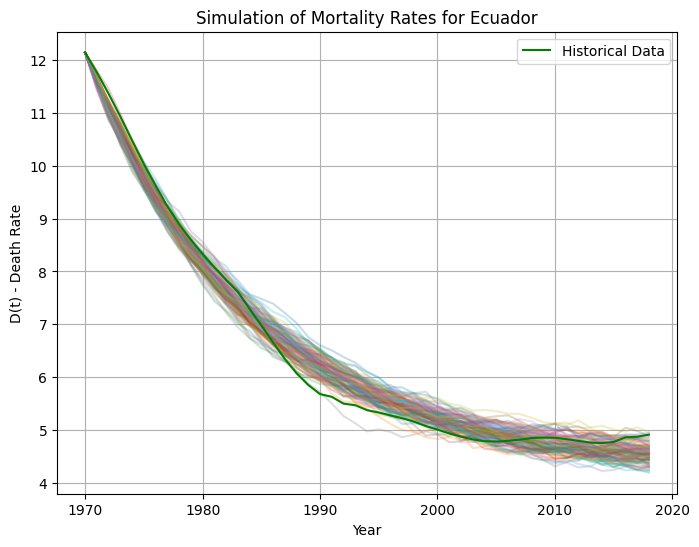

In [4]:
def get_results_deathrate(gamma_d,sigma_d, d_e):
    
    # We start by specifying the starting point of our diffusion process and the time steps
    X_0 = deathrate[0]
    T = len(deathrate)
    dt = 1/T
    N = len(deathrate)
    X = np.zeros(N)
    X[0] = X_0

    X_actual = deathrate
    X_actual = np.array(X_actual)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]

    # Here we define our discretised version of the OU process, using the Euler-Maruyama method
    for t in range(1,N):
        dW = np.sqrt(dt) * np.random.normal(0,1)
        X[t] = X[t-1] + gamma_d * (d_e - X[t-1]) * dt + sigma_d * dW    
    
    return X, X_actual, year_labels

def sim_d(gamma_d, sigma_d, d_e):
    simulations = 100
    plt.figure(figsize=(8, 6)) 
    # We perform 100 simulations of the SDE to get a visual of how close the OU process fits the historical data
    for i in range(simulations):
        X, X_actual, year_labels = get_results_deathrate(gamma_d, sigma_d, d_e)
        plt.plot(year_labels, X, alpha=0.25)
    
    plt.plot(year_labels, X_actual, color="g", label="Historical Data")

    plt.title("Simulation of Mortality Rates for Ecuador")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("D(t) - Death Rate")
    plt.show()
    
sim_d(gamma_optimised_death, sigma_optimised_death, mu_optimised_death)

As we can see, our SDE approximates the historical data with good accuracy.

---
## References

1. **David A. Dickey, Wayne A. Fuller** (1979). *Distribution of the Estimators for Autoregressive Time Series With a Unit Root*. Journal of the American Statistical Association, Volume 74, Issue 366,
427-431.  

2. **Cheng Yong Tang, Song Xi Chen** (2009). *Parameter Estimation and Bias Correction for Diffusion Processes*. Journal of Econometrics, Volume 149, 65-81
427-431.  

3. **José Carlos Garca Franco** (2003). *Maximum Likelihood Estimation of Mean Reverting Processes*. Available at: [http://www.investmentscience.com/Content/howtoArticles/MLE_for_OR_mean_reverting.pdf]

4. **Edward Allen** (2016). *Environmental Variability and Mean-Reverting Processes*. Discrete and Continuous Dynamical Systems - B, Volume 21, Number 7, 2073-2089

5. **Robert H. Shumway, David S. Stoffer** (2010). *Time Series Analysis and its Applications*. Springer. ISBN: 978-1441978646


6. **Quantpie:** "Ornstein Uhlenbeck (OU) Process: solution, mean, variance, covariance, calibration, and simulation" YouTube. Available at: [https://www.youtube.com/watch?v=XrNf2hNHM6I&ab_channel=quantpie]
   Published on Oct 29, 2018.
   